# Problema: otimizar o consumo de energia em três bairros de Tetuan, utilizando dados climáticos e históricos para entender padrões e prever a demanda futura. O objetivo é:

1. Identificar tendências e padrões de consumo.
2. Desenvolver um modelo básico de previsão para ajudar no planejamento.

* Importação das bibliotecas e carregamento do dataset:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import calendar
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv('power consumption.csv')
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3
0,01-01-2017 00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,01-01-2017 00:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,01-01-2017 00:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,01-01-2017 00:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,01-01-2017 00:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [4]:
# Eliminando espaço no nome das variáveis:
df.columns = df.columns.str.strip()

* Tratamento de outliers no dataframe original:

In [5]:
# Tratamento de outliers para o bairro 1:
IQR1 = df['Zone 1'].quantile(0.75) - df['Zone 1'].quantile(0.25)
limite_inferior_1 = df['Zone 1'].quantile(0.25) - (1.5 * IQR1)
limite_superior_1 = df['Zone 1'].quantile(0.75) + (1.5 * IQR1)

# Tratamento de outliers para o bairro 2:
IQR2 = df['Zone 2'].quantile(0.75) - df['Zone 2'].quantile(0.25)
limite_inferior_2 = df['Zone 2'].quantile(0.25) - (1.5 * IQR2)
limite_superior_2 = df['Zone 2'].quantile(0.75) + (1.5 * IQR2)

# Tratamento de outliers para o bairro 3:
IQR3 = df['Zone 3'].quantile(0.75) - df['Zone 3'].quantile(0.25)
limite_inferior_3 = df['Zone 3'].quantile(0.25) - (1.5 * IQR3)
limite_superior_3 = df['Zone 3'].quantile(0.75) + (1.5 * IQR3)

# Máscaras de outliers:
mascara_B1 = (df['Zone 1'] >= limite_inferior_1) & (df['Zone 1'] <= limite_superior_1)
mascara_B2 = (df['Zone 2'] >= limite_inferior_2) & (df['Zone 2'] <= limite_superior_2)
mascara_B3 = (df['Zone 3'] >= limite_inferior_3) & (df['Zone 3'] <= limite_superior_3)

# DataFrame filtrado:
df_limpo = df[mascara_B1 & mascara_B2 & mascara_B3]

* Tratamento e limpeza de dados:

In [6]:
# Resertando o index:
df = df.reset_index()

# Vamos padronizar as datas e alterar o formato da coluna DateTime:
df['DateTime'] = df['DateTime'].astype(str).str.replace(r'[/.]', '-', regex=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Vamos agrupar os dados por mês:
df_mensal = df.copy()
df_mensal.set_index('DateTime', inplace=True)
df_mensal = df_mensal.resample('M').sum()

# Vamos agrupar os dados por dias:
df_dias = df.copy()
df_dias.set_index('DateTime', inplace=True)
df_dias = df_dias.resample('D').sum()

# Vamos alterar o nome das colunas e colocar os registros no indice:
df = df.rename(columns={'Temperature': 'Temperatura', 'Humidity': 'Umidade', 'Wind Speed': 'Velocidade_Vento',
                        'general diffuse flows': 'fluxos_difusos_gerais', 'diffuse flows': 'fluxos_difusos',
                        'Zone 1': 'Bairro1', 'Zone 2': 'Bairro2', 'Zone 3' : 'Bairro3'})
df.set_index('DateTime', inplace=True)

# Alguns dados de temperatura parecem estar com uma formatação um pouco diferente do restante. 
# Podemos perceber no inicio do nosso DataFrame que a temperatura é de 6.559 c°, o que pode querer significar 6.55 c°. 
# Vamos arrumar isso:
df['Temperatura'] = df['Temperatura'].round(2)

# Vamos tratar os DF's que contém os registros por dia e por mês:

#Renomeando colunas:
df_mensal = df_mensal.rename(columns={'Temperature': 'Temperatura','Humidity': 'Umidade', 'Wind Speed': 'Velocidade_Vento',
                        'general diffuse flows': 'fluxos_difusos_gerais', 'diffuse flows': 'fluxos_difusos',
                        'Zone 1': 'Bairro1', 'Zone 2': 'Bairro2', 'Zone 3': 'Bairro3'})

#Arredondando valores de consumo nos bairros:
df_mensal['Bairro1'] = df_mensal['Bairro1'].round(1)
df_mensal['Bairro2'] = df_mensal['Bairro2'].round(1)
df_mensal['Bairro3'] = df_mensal['Bairro3'].round(1)

#Os registros de temperatura foram todos somados, vamos tirar a média da temperatura do mês registrado:
df_mensal['dia_do_mes'] = df_mensal.index.to_series().dt.month.apply(lambda m: calendar.monthrange(df_mensal.index.year[0], m)[1])
df_mensal['Registros_Mes'] = df_mensal['dia_do_mes'] * 144
df_mensal['Temperatura'] = df_mensal['Temperatura'] / df_mensal['Registros_Mes']
df_mensal['Temperatura'] = df_mensal['Temperatura'].round(2)

# Vamos repitir o mesmo processo para a umidade:
df_mensal['Umidade'] = df_mensal['Umidade'] / df_mensal['Registros_Mes']
df_mensal['Umidade'] = df_mensal['Umidade'].round(2)

#Renomeando colunas:
df_dias = df_dias.rename(columns={'Temperature': 'Temperatura','Humidity': 'Umidade', 'Wind Speed': 'Velocidade_Vento',
                        'general diffuse flows': 'fluxos_difusos_gerais', 'diffuse flows': 'fluxos_difusos',
                        'Zone 1': 'Bairro1', 'Zone 2': 'Bairro2', 'Zone 3': 'Bairro3'})

#Arredondando valores de consumo nos bairros:
df_dias['Bairro1'] = df_dias['Bairro1'].round(1)
df_dias['Bairro2'] = df_dias['Bairro2'].round(1)
df_dias['Bairro3'] = df_dias['Bairro3'].round(1)

# Criando uma coluna para os regsitros diarios:
df_dias['Registros_diarios'] = 144
df_dias['Temperatura'] = df_dias['Temperatura'] / df_dias['Registros_diarios']
df_dias['Temperatura'] = df_dias['Temperatura'].round(2)

# Repetindo o processo para umidade:
df_dias['Umidade'] = df_dias['Umidade'] / df_dias['Registros_diarios']
df_dias['Umidade'] = df_dias['Umidade'].round(2)

* Tratamento de outliers no dataframe com consumo mensal:

In [7]:
# Tratamento de outliers para o bairro 1:
IQR_bairro1 = df_mensal['Bairro1'].quantile(0.75) - df_mensal['Bairro1'].quantile(0.25)
limite_inferior_B1 = df_mensal['Bairro1'].quantile(0.25) - (1.5 * IQR_bairro1)
limite_superior_B1 = df_mensal['Bairro1'].quantile(0.75) + (1.5 * IQR_bairro1)

# Tratamento de outliers para o bairro 2:
IQR_bairro2 = df_mensal['Bairro2'].quantile(0.75) - df_mensal['Bairro2'].quantile(0.25)
limite_inferior_B2 = df_mensal['Bairro2'].quantile(0.25) - (1.5 * IQR_bairro2)
limite_superior_B2 = df_mensal['Bairro2'].quantile(0.75) + (1.5 * IQR_bairro2)

# Tratamento de outliers para o bairro 3:
IQR_bairro3 = df_mensal['Bairro3'].quantile(0.75) - df_mensal['Bairro3'].quantile(0.25)
limite_inferior_B3 = df_mensal['Bairro3'].quantile(0.25) - (1.5 * IQR_bairro3)
limite_superior_B3 = df_mensal['Bairro3'].quantile(0.75) + (1.5 * IQR_bairro3)

# Máscaras de outliers:
mascara_b1 = (df_mensal['Bairro1'] >= limite_inferior_B1) & (df_mensal['Bairro1'] <= limite_superior_B1)
mascara_b2 = (df_mensal['Bairro2'] >= limite_inferior_B2) & (df_mensal['Bairro2'] <= limite_superior_B2)
mascara_b3 = (df_mensal['Bairro3'] >= limite_inferior_B3) & (df_mensal['Bairro3'] <= limite_superior_B3)

# DataFrame filtrado:
df_mensal_limpo = df_mensal[mascara_b1 & mascara_b2 & mascara_b3]

# 1. Vamos plotar dois gráficos, um para visualizar qual mês tem a maior e a menor demanda em cada bairro e um para ver qual dia da semana tem maior e menor demanda em cada bairro. Vamos ver também a evolução do consumo de energia elétrica.

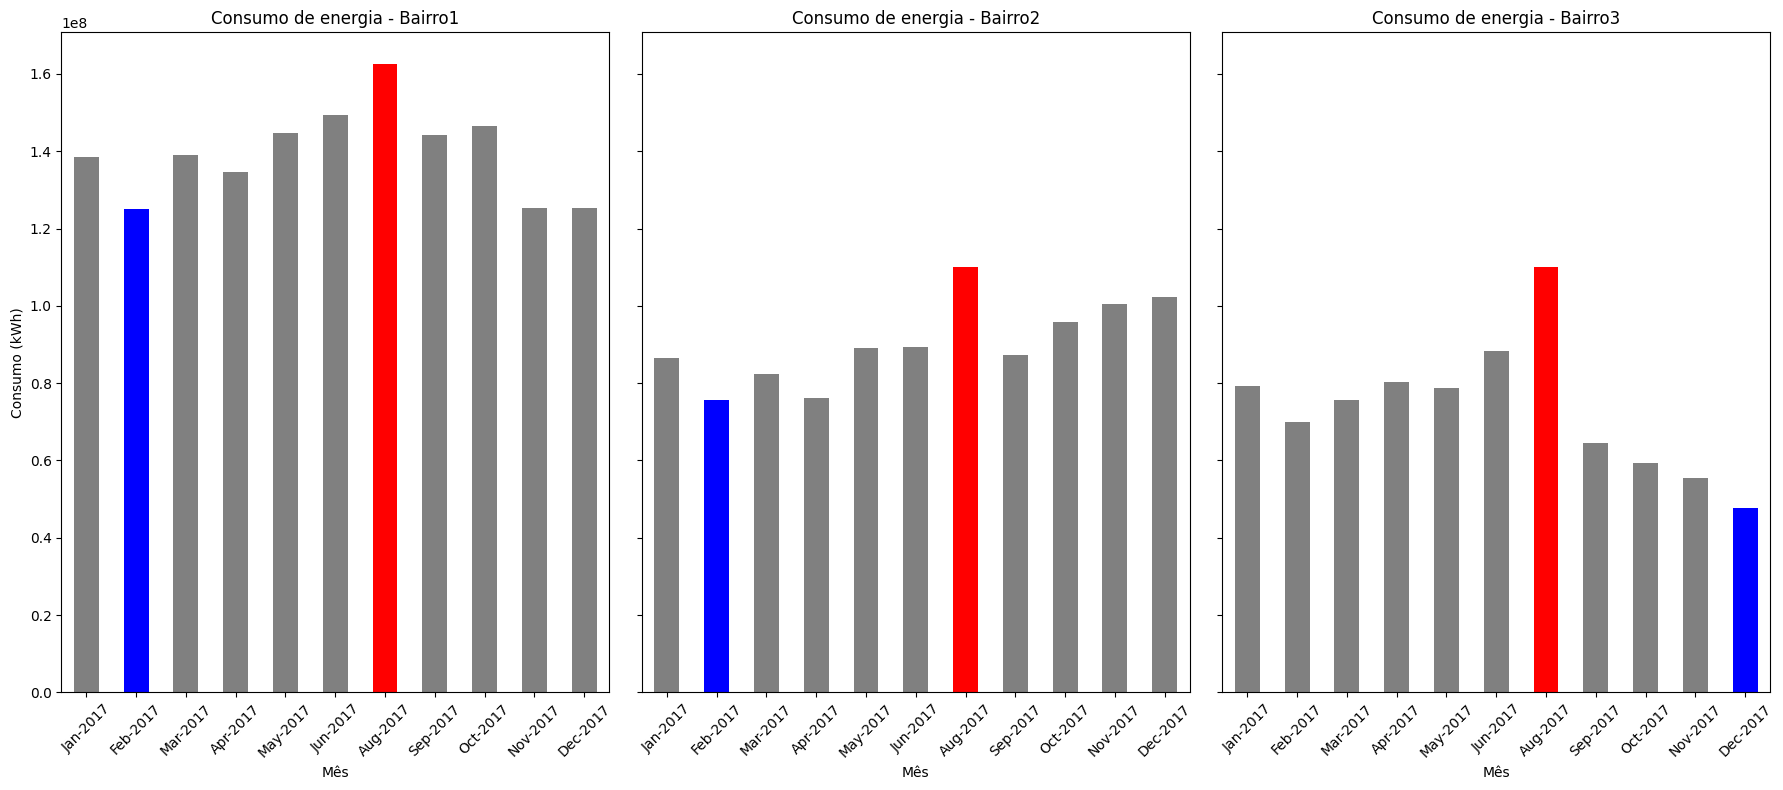

In [8]:
# Lista dos bairros:
bairros = ['Bairro1', 'Bairro2', 'Bairro3']

# Tamanho da figura:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8), sharey=True)

# Itera por cada bairro e criar um subplot:
for i, bairro in enumerate(bairros):
    ax = axes[i]

    # Identifica o mês com maior e menor demanda:
    max_val = df_mensal_limpo[bairro].max()
    min_val = df_mensal_limpo[bairro].min()

    # Destaque para os meses com maior e menor demanda:
    colors = ['red' if x == max_val else 'blue' if x == min_val else 'gray' for x in df_mensal_limpo[bairro]]

    # Plotando o gráfico de barras:
    df_mensal_limpo[bairro].plot(kind='bar', color=colors, ax=ax, legend=False)

    # Titulos e legendas:
    ax.set_title(f"Consumo de energia - {bairro}")
    ax.set_xlabel('Mês')
    ax.set_ylabel("Consumo (kWh)" if i == 0 else "")
    ax.set_xticks(range(len(df_mensal_limpo.index)))
    ax.set_xticklabels(df_mensal_limpo.index.strftime('%b-%Y'), rotation=45)

# Ajuste nos espaços entre os gráficos:
plt.tight_layout()
plt.show()

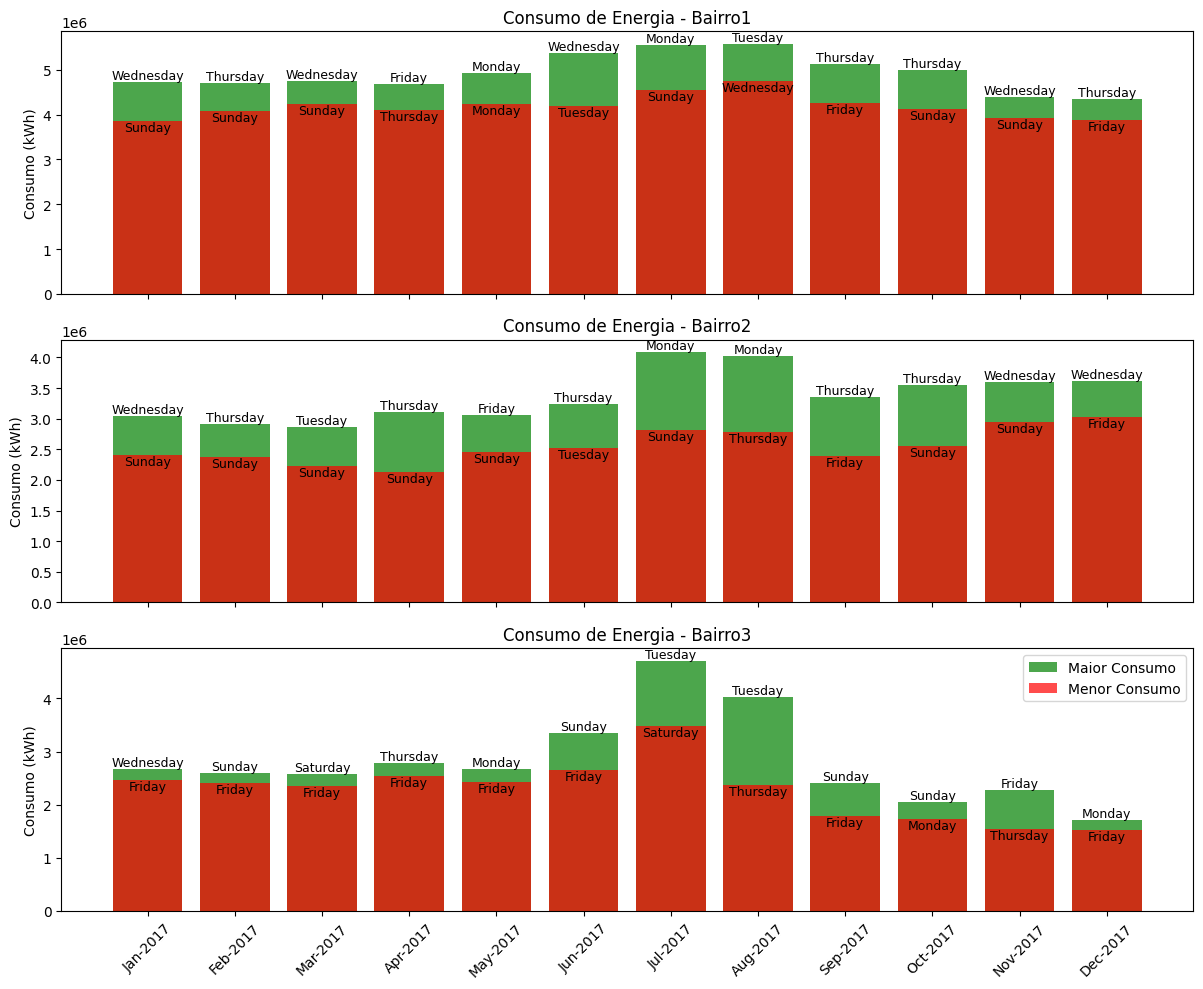

In [9]:
# Garantir que o índice de datas está no formato datetime
df_dias.index = pd.to_datetime(df_dias.index)

# Criar colunas auxiliares para ordenação
df_dias["Dia_da_Semana"] = df_dias.index.day_name()  # Nome do dia da semana
df_dias["Mês_Ano"] = df_dias.index.strftime('%b-%Y')  # Nome do mês para exibição
df_dias["Ordem_Mês_Ano"] = df_dias.index.to_period("M")  # Período para ordenação correta

# Criar a figura e os eixos
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
bairros = ["Bairro1", "Bairro2", "Bairro3"]
cores = {"max": "green", "min": "red"}

# Iterar sobre os bairros
for i, bairro in enumerate(bairros):
    ax = axes[i]  

    # Encontrar dias de maior e menor consumo
    maximos = df_dias.loc[df_dias.groupby("Mês_Ano")[bairro].idxmax(), ["Mês_Ano", "Dia_da_Semana", bairro]]
    minimos = df_dias.loc[df_dias.groupby("Mês_Ano")[bairro].idxmin(), ["Mês_Ano", "Dia_da_Semana", bairro]]

    # Adicionar coluna de ordenação
    maximos["Ordem_Mês_Ano"] = pd.to_datetime(maximos["Mês_Ano"], format='%b-%Y')
    minimos["Ordem_Mês_Ano"] = pd.to_datetime(minimos["Mês_Ano"], format='%b-%Y')

    # Renomear colunas
    maximos = maximos.rename(columns={"Dia_da_Semana": "Dia_Max", bairro: "Consumo_Max"})
    minimos = minimos.rename(columns={"Dia_da_Semana": "Dia_Min", bairro: "Consumo_Min"})

    # Criar DataFrame combinado e ordenar corretamente
    df_plot = pd.merge(maximos, minimos, on=["Mês_Ano", "Ordem_Mês_Ano"]).sort_values("Ordem_Mês_Ano")

    # Plotar os valores
    ax.bar(df_plot["Mês_Ano"], df_plot["Consumo_Max"], color=cores["max"], label="Maior Consumo", alpha=0.7)
    ax.bar(df_plot["Mês_Ano"], df_plot["Consumo_Min"], color=cores["min"], label="Menor Consumo", alpha=0.7)

    # Configuração do eixo
    ax.set_title(f"Consumo de Energia - {bairro}")
    ax.set_ylabel("Consumo (kWh)")

    # Exibir os dias nos rótulos das barras
    for j in range(len(df_plot)):
        ax.text(j, df_plot["Consumo_Max"].iloc[j], df_plot["Dia_Max"].iloc[j], ha='center', va='bottom', fontsize=9, color='black')
        ax.text(j, df_plot["Consumo_Min"].iloc[j], df_plot["Dia_Min"].iloc[j], ha='center', va='top', fontsize=9, color='black')

# Configuração do eixo X
axes[-1].set_xticks(range(len(df_plot["Mês_Ano"])))  
axes[-1].set_xticklabels(df_plot["Mês_Ano"], rotation=45)

# Legenda e layout
plt.legend()
plt.tight_layout()
plt.show()


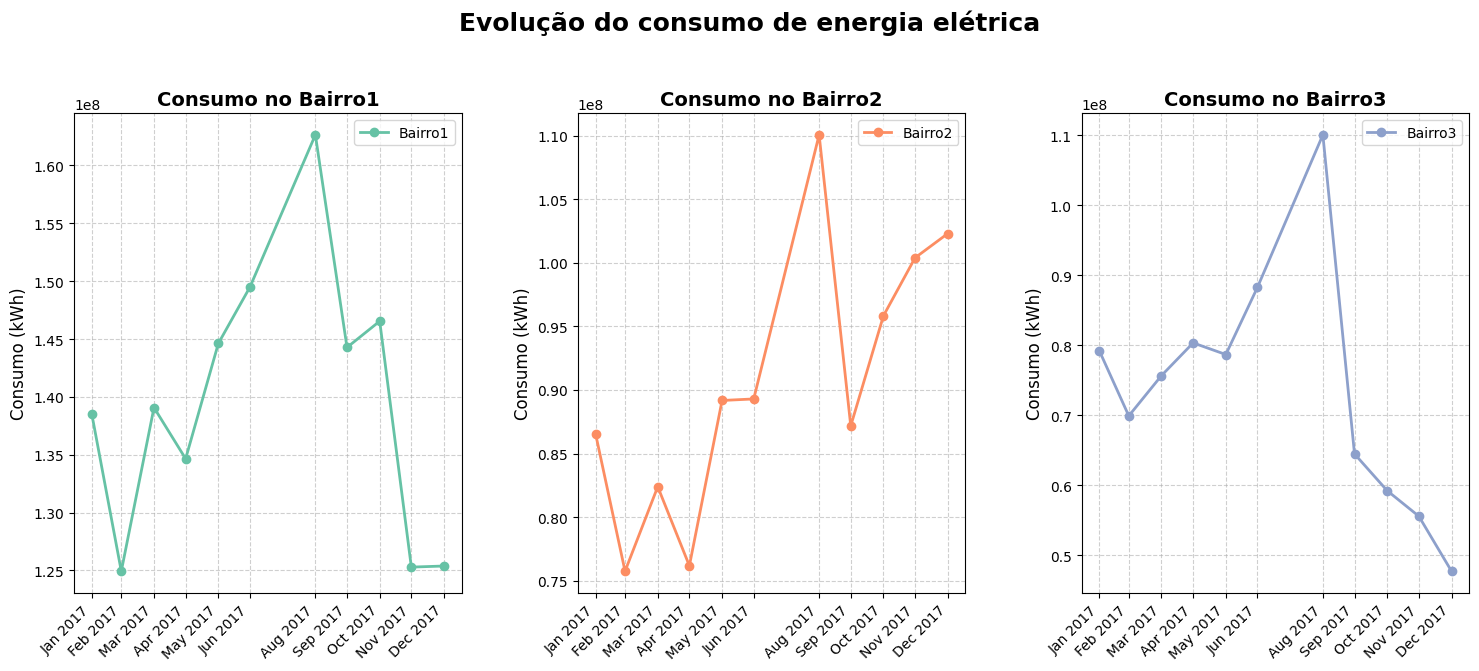

In [10]:
bairros = ['Bairro1', 'Bairro2', 'Bairro3']

# Tamanho da figura:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8),sharex=True)
plt.suptitle('Evolução do consumo de energia elétrica', fontsize=18, fontweight='bold')

# Formatando as datas para exibir todos os meses no eixo X:
labels_formatadas = df_mensal_limpo.index.strftime('%b %Y')  
posicoes_x = range(len(df_mensal_limpo.index))  # Criando posições para cada rótulo no eixo X

# Iteração por cada bairro:
for i, bairro in enumerate(bairros):
    ax = axes[i]
    ax.plot(df_mensal_limpo.index, df_mensal_limpo[bairro], marker='o', linestyle='-', 
            markersize=6, linewidth=2, label=bairro, color=plt.cm.Set2(i))
    
    ax.set_title(f'Consumo no {bairro}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Consumo (kWh)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Ajustando o eixo X para mostrar todos os meses
    ax.set_xticks(df_mensal_limpo.index)
    ax.set_xticklabels(labels_formatadas, rotation=45, ha='right', fontsize=10)

# Ajustando espaçamento entre gráficos
plt.subplots_adjust(top=0.85, bottom=0.25, wspace=0.3)

plt.show()
    

* Elaboração do modelo de regressão linear:

In [11]:
# Criamos um Dataframe somente com o consumo mensal dos bairros:  
df_mensal_bairros = df_mensal_limpo[['Bairro1', 'Bairro2', 'Bairro3']].copy()
df_mensal_bairros

,Bairro1,Bairro2,Bairro3
DateTime,,,
2017-01-31,138529051.1,86576801.2,79218569.6
2017-02-28,124934558.6,75752381.8,69894728.7
2017-03-31,139076658.4,82396232.9,75654470.3
2017-04-30,134653398.7,76178734.8,80322484.4
2017-05-31,144615784.9,89178613.0,78660594.7
2017-06-30,149495936.4,89298411.6,88261667.4
2017-08-31,162646686.3,110065350.8,110032666.1
2017-09-30,144273663.7,87179467.4,64466490.7
2017-10-31,146542674.5,95837586.7,59210920.9



Previsões para Bairro1:
  Mês 13: 139290639 unidades
  Mês 14: 139248497 unidades
  Mês 15: 139206356 unidades
  Mês 16: 139164214 unidades
  Mês 17: 139122073 unidades
  Mês 18: 139079931 unidades
  Mês 19: 139037790 unidades
  Mês 20: 138995648 unidades
  Mês 21: 138953507 unidades
  Mês 22: 138911365 unidades
  Mês 23: 138869224 unidades
  Mês 24: 138827082 unidades


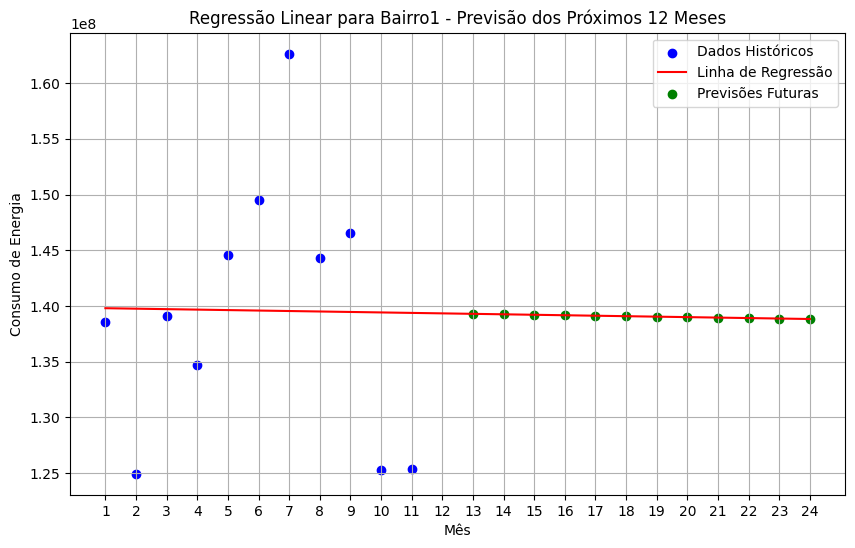


Previsões para Bairro2:
  Mês 13: 107043397 unidades
  Mês 14: 109411051 unidades
  Mês 15: 111778706 unidades
  Mês 16: 114146360 unidades
  Mês 17: 116514014 unidades
  Mês 18: 118881668 unidades
  Mês 19: 121249323 unidades
  Mês 20: 123616977 unidades
  Mês 21: 125984631 unidades
  Mês 22: 128352286 unidades
  Mês 23: 130719940 unidades
  Mês 24: 133087594 unidades


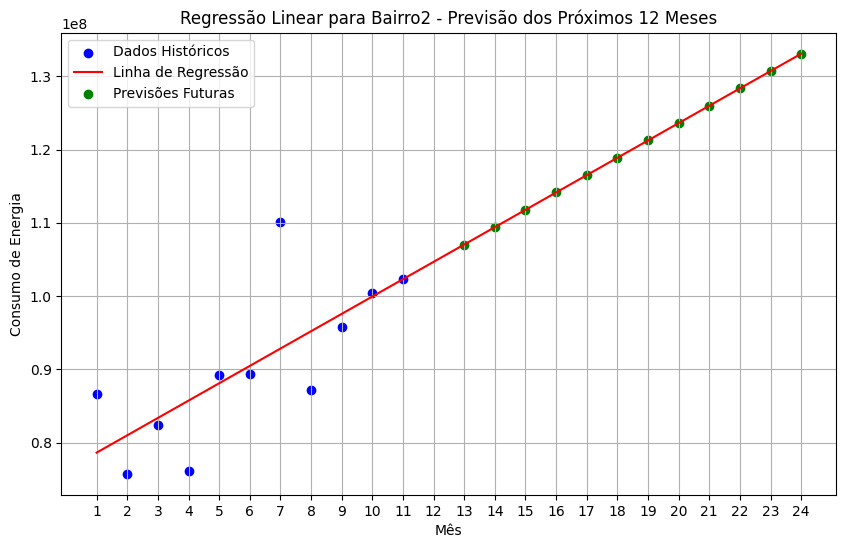


Previsões para Bairro3:
  Mês 13: 56713158 unidades
  Mês 14: 54308516 unidades
  Mês 15: 51903875 unidades
  Mês 16: 49499233 unidades
  Mês 17: 47094591 unidades
  Mês 18: 44689950 unidades
  Mês 19: 42285308 unidades
  Mês 20: 39880667 unidades
  Mês 21: 37476025 unidades
  Mês 22: 35071383 unidades
  Mês 23: 32666742 unidades
  Mês 24: 30262100 unidades


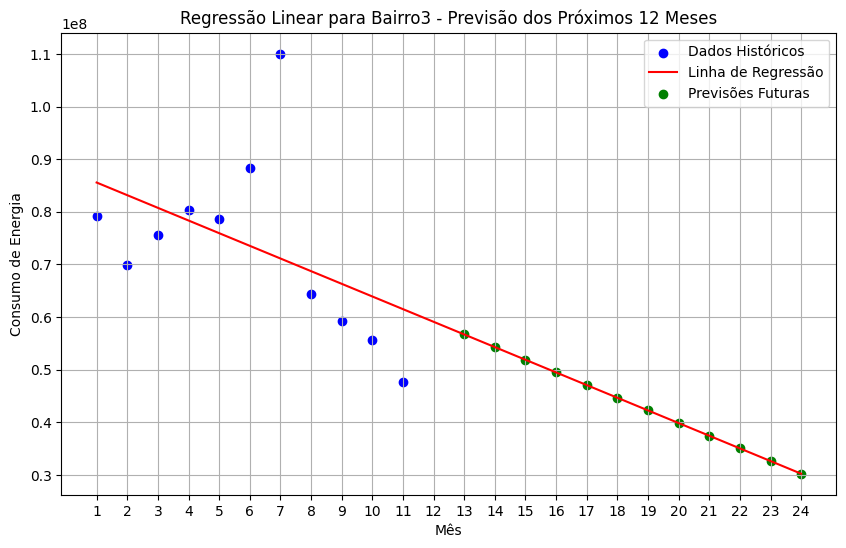

In [12]:
# números de mês de 1 a 12 para os dados históricos:
X_hist = np.arange(1, 12).reshape(-1,1)

bairros = ['Bairro1', 'Bairro2', 'Bairro3']

for bairro in bairros:
    # Extraindo os dados históricos para o bairro:
    y_hist = df_mensal_bairros[bairro].values

    # Criar e ajustar o modelo de regressão linear com os 12 meses históricos:
    modelo = LinearRegression()
    modelo.fit(X_hist, y_hist)

    # previsão para os próximos 12 meses(meses: 13 à 24):
    X_future = np.arange(13,25).reshape(-1,1)
    previsoes_futuro = modelo.predict(X_future)

    # Para uma visualização completa, podemos calcular a linha de regressão para meses 1 a 24:
    X_total = np.arange(1, 25).reshape(-1,1)
    previsoes_total = modelo.predict(X_total)

    # Exibir as previsões para os próximos 12 meses
    print(f"\nPrevisões para {bairro}:")
    for mes, previsao in zip(np.arange(13, 25), previsoes_futuro):
        print(f"  Mês {mes}: {previsao:.0f} unidades")
    
    # Plotar os resultados para o bairro
    plt.figure(figsize=(10, 6))
    plt.scatter(X_hist, y_hist, color='blue', label='Dados Históricos')  # Dados históricos (meses 1 a 12)
    plt.plot(X_total, previsoes_total, color='red', label='Linha de Regressão')  # Linha ajustada para meses 1 a 24
    plt.scatter(X_future, previsoes_futuro, color='green', label='Previsões Futuras')  # Previsões para meses 13 a 24
    plt.xlabel('Mês')
    plt.ylabel('Consumo de Energia')
    plt.title(f'Regressão Linear para {bairro} - Previsão dos Próximos 12 Meses')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 25))  # Exibe os meses de 1 a 24 no eixo X
    plt.show()

